## Midterm Project, Group 2

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import box
import networkx as nx
from keplergl import KeplerGl

In [2]:
## City und districts ##
place = "Graz, Austria"
main_crs = "EPSG:31256"

gdf_boundaries = ox.features_from_place(
    place,
    tags={"boundary": "administrative"}
)
## with filter, just districts graz
df_districts = gdf_boundaries[gdf_boundaries["admin_level"] == "9"]
df_districts = df_districts.to_crs(main_crs)


In [3]:
## OSM Tags ##
tags_osm = {
    "leisure": ["park", "pitch", "playground", "sports_centre", "stadium"],
    "natural": ["water", "wetland"],
    #"route": ["hiking", "foot", "bicycle", "mtb"], => empty
}
graz_tags = ox.features_from_place(place, tags=tags_osm).to_crs(main_crs)

graz_leisure = graz_tags[graz_tags["leisure"].notna()]
graz_water = graz_tags[graz_tags["natural"].notna()]
#graz_routes = graz_tags[graz_tags["route"].notna()]

In [5]:
## Plot
#fig, ax = plt.subplots(figsize=(12,12))
#df_districts.boundary.plot(ax=ax, color="black", linewidth=1)
#graz_leisure.plot(ax=ax, color="green", alpha=0.6, edgecolor="none")
#graz_water.plot(ax=ax, color="blue", alpha=0.6, edgecolor="none")
##graz_routes.plot(ax=ax, color="black", alpha=0.6, edgecolor="none")
#ax.set_title("leisure, natural, routes, Graz, districts")
#ax.set_axis_off()
#plt.show()

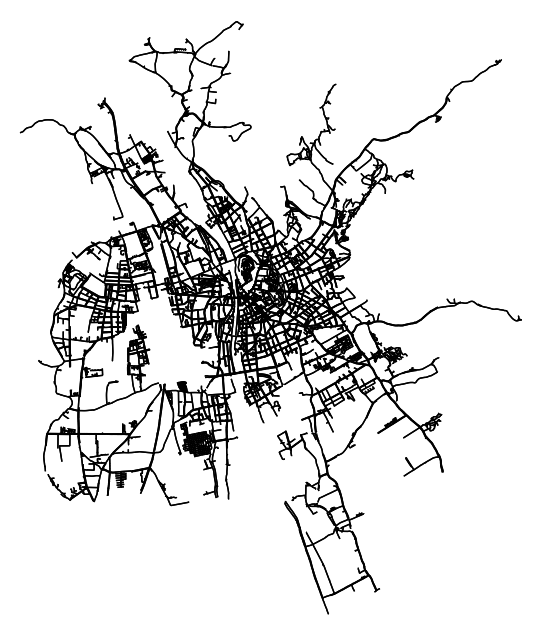

In [4]:
## Graph ##
#only dedicated pedestrian paths
filter = '["highway"~"footway|path|pedestrian"]'
graph2 = ox.graph_from_place(place, network_type="walk", custom_filter=filter, simplify=True)
graph2 = ox.project_graph(graph2, to_crs=main_crs)
fig, ax = ox.plot_graph(graph2, node_size=0, bgcolor="white", edge_color="black")

In [5]:
place = "Graz, Austria"
main_crs = "EPSG:31256"
raster_path = r"data/2021350_Mosaik_LC.tif"
output_vector = r"data/LC_graz_25m_majority.gpkg"
target_resolution = (25, 25)  

graz_boundary = ox.geocode_to_gdf(place).to_crs(main_crs)

with rasterio.open(raster_path) as src:
    out_image, out_transform = mask(
        src,
        [graz_boundary.geometry.iloc[0]],
        crop=True
    )
    lc = out_image[0]  

    height, width = lc.shape
    left, top = out_transform * (0, 0)
    right, bottom = out_transform * (width, height)

    dst_transform, dst_width, dst_height = calculate_default_transform(
        src.crs,        
        src.crs,
        width, height,
        left, bottom, right, top,
        resolution=target_resolution
    )

    lc_250m = np.empty((dst_height, dst_width), dtype=lc.dtype)

    reproject(
        source=lc,
        destination=lc_250m,
        src_transform=out_transform,
        src_crs=src.crs,
       dst_transform=dst_transform,
        dst_crs=src.crs,
        resampling=Resampling.mode 
    )

    nodata = src.nodata
    valid_mask = lc_250m != nodata if nodata is not None else np.ones_like(lc_250m, dtype=bool)

    results = [
        {"geometry": shape(geom), "lc": int(value)}
        for geom, value in shapes(lc_250m, mask=valid_mask, transform=dst_transform)
    ]

gdf = gpd.GeoDataFrame(results, crs=main_crs)

gdf.to_file(output_vector, driver="GPKG")



In [ ]:
# only keeping vegetation classes and green spaces, dissolving them and keeping only polygons >= 100 sqm
gdf.loc[gdf['lc'].isin([1, 3, 6]), 'lc'] = 1

landcover_dissolved = gdf.dissolve(by='lc', as_index=False)

landcover_dissolved_green = landcover_dissolved[landcover_dissolved['lc'] == 1]

landcover_dissolved_green['area'] = landcover_dissolved_green.geometry.area

landcover_dissolved_green_100 = landcover_dissolved_green[landcover_dissolved_green['area'] >= 100]



Remaining polygons: 1


c:\Users\micha\Uni1\GIS Analysetechniken 2\Gis Anal2\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
# matching the landcover filter for osm data as well
graz_leisure = graz_leisure[graz_leisure.geometry.type.isin(['Polygon', 'MultiPolygon'])]

graz_leisure['area'] = graz_leisure.geometry.area
graz_leisure = graz_leisure[graz_leisure['area'] >= 100]
graz_leisure = graz_leisure.drop(columns=['area'])

landcover_simple = landcover_dissolved_green_100[['geometry', 'lc']].copy()
graz_leisure_simple = graz_leisure[['geometry']].copy()
graz_leisure_simple['lc'] = 1  

# merging and dissolving datasets
merged = gpd.GeoDataFrame(
    pd.concat([landcover_simple, graz_leisure_simple], ignore_index=True),
    crs=main_crs
)

merged_dissolved = merged.dissolve(by='lc', as_index=False)

In [ ]:
# assigning IDs to green spaces and extracting boundary points at 50 meter intervals
merged_dissolved['green_id'] = range(1, len(merged_dissolved) + 1)

green_points = []
for idx, row in merged_dissolved.iterrows():
    boundary = row.geometry.boundary
    distances = range(0, int(boundary.length), 50)
    points = [boundary.interpolate(d) for d in distances]
    for point in points:
        green_points.append({
            'green_id': row['green_id'],
            'geometry': point,
        })
green_points = gpd.GeoDataFrame(green_points, crs=main_crs)

In [ ]:
# extracting building centroids as analysis points from osm data
tags_buildings = {"building": True}
buildings = ox.features_from_place(place, tags=tags_buildings).to_crs(main_crs)
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]
analysis_points = buildings.copy()
analysis_points['geometry'] = analysis_points.geometry.centroid

In [ ]:
# snapping green space and analysis points to network using nearest node
green_points['nearest_node'] = ox.distance.nearest_nodes(
    graph2, 
    green_points.geometry.x, 
    green_points.geometry.y
)

analysis_points['nearest_node'] = ox.distance.nearest_nodes(
    graph2,
    analysis_points.geometry.x,
    analysis_points.geometry.y
)

# removing duplicate nodes
green_points = green_points.drop_duplicates(subset=['nearest_node'])
analysis_points = analysis_points.drop_duplicates(subset=['nearest_node'])

In [ ]:
print("\nPreprocessing complete!")
print(f"Green entry points: {len(green_points)}")
print(f"Analysis points: {len(analysis_points)}")
print(f"Network nodes: {len(graph2.nodes)}")
print(f"Network edges: {len(graph2.edges)}")


Preprocessing complete!
Green spaces: 1
Green entry points: 5095
Analysis points: 6772
Network nodes: 13106
Network edges: 33176


In [ ]:
# Sources of Network Analysis: Node IDs of green points without possible NaN-Values
green_sources = green_points['nearest_node'].dropna().astype(int).tolist()

distances = nx.multi_source_dijkstra_path_length(
    G=graph2,
    sources=green_sources,
    weight='length',
    cutoff=10000  # Meter
)

In [ ]:
analysis_points['dist_green'] = analysis_points['nearest_node'].map(distances)

In [ ]:
bounds = graz_boundary.to_crs(main_crs).total_bounds
minx, miny, maxx, maxy = bounds
res = 100  # Meter

polys = []
for x in np.arange(minx, maxx, res):
    for y in np.arange(miny, maxy, res):
        polys.append(box(x, y, x+res, y+res))

grid = gpd.GeoDataFrame(geometry=polys, crs=main_crs)

In [ ]:
# add Building Centroids to the Grid with a spatial join
analysis_in_grid = gpd.sjoin(
    analysis_points[['geometry', 'dist_green']],
    grid[['geometry']],
    how='inner',
    predicate='within'
)

# mean value per grid cell
grid['dist_green_mean'] = analysis_in_grid.groupby('index_right')['dist_green'].mean()

In [ ]:
grid['dist_green_mean'].describe()

In [ ]:
bins = [0, 100, 200, 300, 400, 500, 600, grid['dist_green_mean'].max()]
labels = ['0-100 m', '100–200 m', '200–300 m', '300–400 m', '400-500 m', '500-600 m', '>600 m']

grid['dist_class'] = pd.cut(
    grid['dist_green_mean'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [ ]:
grid_clean = grid.dropna(subset=['dist_green_mean'])

In [ ]:
# Display the interactive visualization with Kepler
config = {
    "version": "v1",
    "config": {
        "mapState": {
            "latitude": 47.07,   # Graz
            "longitude": 15.44,
            "zoom": 12,
        }
    }
}
map = KeplerGl(height=600)
map.add_data(data=grid_clean, name='Distances to Green Spaces in Graz')
map.config = config
map.save_to_html(file_name="green_graz.html")
map